In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ray

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = ray.data.read_csv("codon_usage.csv")
df

2024-04-22 05:34:50,407	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Dataset(
   num_rows=13027,
   schema={
      Kingdom: string,
      DNAtype: int64,
      SpeciesID: int64,
      Ncodons: int64,
      SpeciesName: string,
      UUU: string,
      UUC: double,
      UUA: double,
      UUG: double,
      CUU: double,
      CUC: double,
      CUA: double,
      CUG: double,
      AUU: double,
      AUC: double,
      AUA: double,
      AUG: double,
      GUU: double,
      GUC: double,
      GUA: double,
      GUG: double,
      GCU: double,
      GCC: double,
      GCA: double,
      GCG: double,
      CCU: double,
      CCC: double,
      CCA: double,
      CCG: double,
      UGG: double,
      GGU: double,
      GGC: double,
      GGA: double,
      GGG: double,
      UCU: double,
      UCC: double,
      UCA: double,
      UCG: double,
      AGU: double,
      AGC: double,
      ACU: double,
      ACC: double,
      ACA: double,
      ACG: double,
      UAU: double,
      UAC: double,
      CAA: double,
      CAG: double,
      AAU: double,
      

In [4]:
df = df.to_pandas()
df.dtypes.head(20)

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
UUU             object
UUC            float64
UUA            float64
UUG            float64
CUU            float64
CUC            float64
CUA            float64
CUG            float64
AUU            float64
AUC            float64
AUA            float64
AUG            float64
GUU            float64
GUC            float64
GUA            float64
dtype: object

In [5]:
df = df[pd.to_numeric(df["UUU"], errors="coerce").notnull()].copy()

df = df.copy()  # to avoid irritating SettingWithCopyWarning

df["UUU"] = df.loc[:, "UUU"].astype(float)
df["UUC"] = df.loc[:, "UUC"].astype(float)

df.dtypes.head(20)

Kingdom         object
DNAtype          int64
SpeciesID        int64
Ncodons          int64
SpeciesName     object
UUU            float64
UUC            float64
UUA            float64
UUG            float64
CUU            float64
CUC            float64
CUA            float64
CUG            float64
AUU            float64
AUC            float64
AUA            float64
AUG            float64
GUU            float64
GUC            float64
GUA            float64
dtype: object

In [6]:
df = df.loc[df["Kingdom"] != "plm", :]
df = df.loc[df["Ncodons"] >= 1000, :]
df = df.drop(["DNAtype", "SpeciesID", "Ncodons", 'SpeciesName'], axis = "columns")

In [7]:
df = df.replace(
    {
        "Kingdom" : {
        "arc" : 0,
        "bct" : 1,
        "pln" : 2,
        "inv" : 2,
        "vrt" : 2,
        "mam" : 2,
        "rod" : 2,
        "pri" : 2,
        "phg" : 3,
        "vrl" : 4,
        }
    }
)

In [8]:
y = df.pop("Kingdom")

In [9]:
y

0        4
1        4
2        4
3        4
4        4
        ..
13022    2
13023    2
13024    2
13025    2
13026    2
Name: Kingdom, Length: 13008, dtype: int64

<Axes: title={'center': 'Occurrences of kingdoms in %'}, xlabel='Kingdom', ylabel='%'>

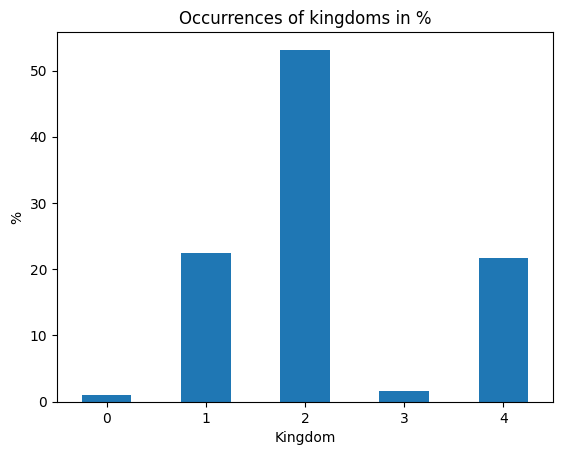

In [10]:
n = len(y)
counted = y.value_counts().sort_index()
counted = counted / n * 100
counted.plot.bar(title = "Occurrences of kingdoms in %", ylabel = "%", rot=0)

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=0, stratify=y
)

In [12]:
import joblib
from ray.util.joblib import register_ray
register_ray()

In [13]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

Without ray

In [26]:
%%time

clf = KNeighborsClassifier()

clf.fit(X_train, y_train)

y_pred_score_train = clf.predict(X_train)
y_pred_score_test = clf.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

F1 train: 92.51%
F1 test: 91.35%
CPU times: total: 2.89 s
Wall time: 1.64 s


With ray

In [27]:
%%time

clf = KNeighborsClassifier()

with joblib.parallel_backend('ray'):
    clf.fit(X_train, y_train)

y_pred_score_train = clf.predict(X_train)
y_pred_score_test = clf.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

F1 train: 92.51%
F1 test: 91.35%
CPU times: total: 2.69 s
Wall time: 1.66 s


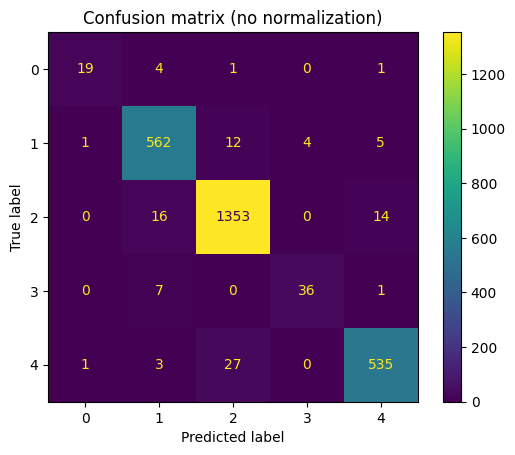

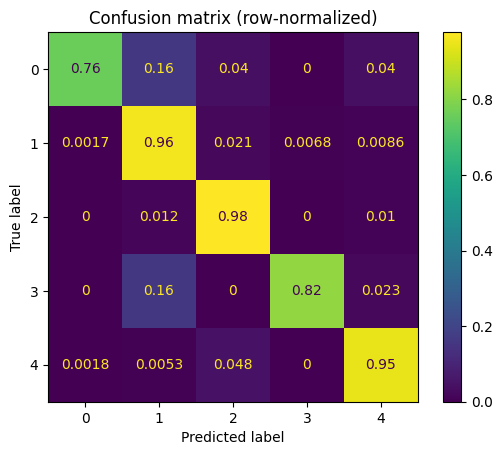

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion matrix (no normalization)")
plt.show()


ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, normalize="true")
plt.title("Confusion matrix (row-normalized)")
plt.show()

In [29]:
from time import time

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_neighbors": list(range(1, 51)),
}

multiclass_f1 = make_scorer(
    f1_score,
    average="macro",
    greater_is_better=True,
)

Without ray

In [30]:
clf = KNeighborsClassifier()

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()
cv.fit(X_train, y_train)
time_end = time()

print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

Optimal number of neighbors: 1
Tuning time: 47.71 s
F1 train: 100.00%
F1 test: 89.16%


With ray

In [31]:
clf = KNeighborsClassifier()

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()

with joblib.parallel_backend('ray'):
    cv.fit(X_train, y_train)
    
time_end = time()

print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

2024-04-22 05:42:34,905	WARNING pool.py:589 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


Optimal number of neighbors: 1
Tuning time: 23.28 s
F1 train: 100.00%
F1 test: 89.16%


In [32]:
param_grid = {
    "n_neighbors" : list(range(5, 25)),
    "metric" : ("euclidean", "cityblock", "cosine"),
    "weights" : ("uniform", "distance"),
}

Without ray

In [33]:
clf = KNeighborsClassifier()

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()
cv.fit(X_train, y_train)
time_end = time()

print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

Optimal number of neighbors: 6
Tuning time: 146.07 s
F1 train: 100.00%
F1 test: 91.53%


With ray

In [34]:
clf = KNeighborsClassifier()

cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=multiclass_f1,
    cv=5,
)

time_start = time()

with joblib.parallel_backend('ray'):
    cv.fit(X_train, y_train)
    
time_end = time()

print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Tuning time: {time_end - time_start:.2f} s")

y_pred_score_train = cv.predict(X_train)
y_pred_score_test = cv.predict(X_test)

f1_train = f1_score(y_train, y_pred_score_train, average="macro")
f1_test = f1_score(y_test, y_pred_score_test, average="macro")

print(f"F1 train: {100 * f1_train:.2f}%")
print(f"F1 test: {100 * f1_test:.2f}%")

Optimal number of neighbors: 6
Tuning time: 71.10 s
F1 train: 100.00%
F1 test: 91.53%


In [35]:
print(f"Optimal number of neighbors: {cv.best_params_['n_neighbors']}")
print(f"Optimal metric: {cv.best_params_['metric']}")
print(f"Optimal weights: {cv.best_params_['weights']}")

Optimal number of neighbors: 6
Optimal metric: cosine
Optimal weights: distance


With ray but different approach 

In [37]:
from ray import tune

In [47]:
param_grid = {
    "n_neighbors" : tune.grid_search(list(range(5, 25))),
    "metric" : tune.choice(["euclidean", "cityblock", "cosine"]),
    "weights" : tune.choice(["uniform", "distance"]),
}

def objective(config):
    clf = KNeighborsClassifier(n_neighbors=config["n_neighbors"], metric=config["metric"], weights=config["weights"])
    clf.fit(X_train, y_train)
    y_pred_score_train = cv.predict(X_train)
    score = f1_score(y_train, y_pred_score_train, average="macro")
    return {"score": score}

tuner = tune.Tuner(objective, param_space=param_grid)

time_start = time()
results = tuner.fit()
time_end = time()

print(f"Tuning time: {time_end - time_start:.2f} s")
print(results.get_best_result(metric="score", mode="min").config)

FileNotFoundError: [WinError 206] Nazwa pliku lub jej rozszerzenie są za długie: 'C:\\Users\\k2002\\AppData\\Local\\Temp\\ray\\session_2024-04-22_05-34-47_643985_6892\\artifacts\\2024-04-22_06-21-49\\objective_2024-04-22_06-21-49\\driver_artifacts\\objective_d6ebe_00013_13_metric=euclidean,n_neighbors=18,weights=distance_2024-04-22_06-21-54'

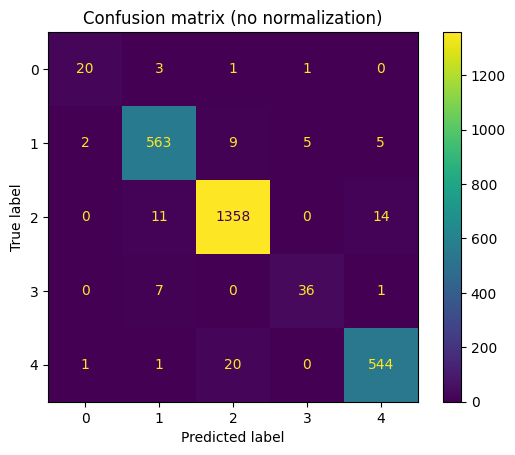

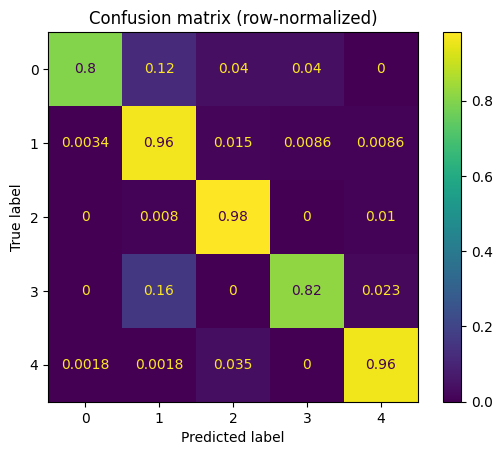

In [36]:
ConfusionMatrixDisplay.from_estimator(cv, X_test, y_test)
plt.title("Confusion matrix (no normalization)")
plt.show()

ConfusionMatrixDisplay.from_estimator(cv, X_test, y_test, normalize="true")
plt.title("Confusion matrix (row-normalized)")
plt.show()